In [196]:
# import libraries
import streamlit as st
import pandas as pd
import numpy as np

import streamlit.components.v1 as components

from specklepy.api import operations
from specklepy.api.client import SpeckleClient
from specklepy.api.credentials import get_default_account
from specklepy.transports.server import ServerTransport


from typing import Any, List

In [197]:
import os
TOKEN_ID = os.environ.get('SPECKLE_TOKEN')

In [198]:
HOST = "https://speckle.xyz"
STREAM_ID = "0b7b9e7705"

def get_authenticated_client() -> SpeckleClient:
    """
    This assumes you already have a local account. If you don't already have one, you'll need
    to download the Speckle Manager and add an account for your server (which can be localhost).
    See the docs for more info: https://speckle.guide/user/manager.html
    """
    client = SpeckleClient(host=HOST)
    client.authenticate(token=TOKEN_ID)
    
    # account = get_default_account()
    # client.authenticate(token=TOKEN_ID)

    return client

def get_branches(client: SpeckleClient, stream_id: str = STREAM_ID) -> Any:
    # get the specified commit data
    stream = client.stream.get(STREAM_ID)
    # create an authenticated server transport from the client and receive the commit obj
    transport = ServerTransport(STREAM_ID, client)
    # get all the branches
    branches = client.branch.list(stream_id=STREAM_ID, branches_limit= 100)
    
    return branches

# def receive_data(client: SpeckleClient, stream_id: str = STREAM_ID, commit_id: str = COMMIT_ID) -> Any:
#     transport = ServerTransport(client, stream_id)

#     commit = client.commit.get(stream_id, commit_id)
#     data = operations.receive(commit.referencedObject, transport)

#     return data["data"]

def speckle_df(branches) -> pd.DataFrame:
    a = [(b.name, b.id, b) for b in branches]

    # create pandas dataframe
    df = pd.DataFrame(a, columns=['branch', 'id', 'b-object'])
    df = df.join(df.branch.str.split('/', expand=True))
    df = df.rename(columns={0:'revision', 1:'area',2:'metric'}, inplace=False)
    
    df = df[df['revision'] != 'main']
    
    return df

In [199]:

# create and authenticate a client
client = get_authenticated_client()
branches = get_branches(client = client, stream_id= STREAM_ID )
df_branches = speckle_df(branches)

# df_data # TODO 

2022-03-07 15:51:14.083 INFO    gql.transport.requests: >>> {"query": "query Server {\n  serverInfo {\n    name\n    company\n    description\n    adminContact\n    canonicalUrl\n    version\n    roles {\n      name\n      description\n      resourceTarget\n    }\n    scopes {\n      name\n      description\n    }\n    authStrategies {\n      id\n      name\n      icon\n    }\n  }\n}"}
2022-03-07 15:51:14.198 INFO    gql.transport.requests: <<< {"data":{"serverInfo":{"name":"Speckle XYZ","company":"AEC Systems Ltd.","description":"The Official Speckle Server - Empowering Your Design and Construction Data.","adminContact":"office@speckle.systems","canonicalUrl":null,"version":"2.3.14","roles":[{"name":"stream:reviewer","description":"Reviewers can only view (read) the data from this stream.","resourceTarget":"streams"},{"name":"stream:owner","description":"Owners have full access, including deletion rights & access control.","resourceTarget":"streams"},{"name":"stream:contributor","desc

In [200]:
df_branches.head() #use df in the application

,branch,id,b-object,revision,area,metric
1,rev1/cfd/0,1e986514a3,id='1e986514a3' name='rev1/cfd/0' description=...,rev1,cfd,0
2,rev1/cfd/90,2f628a5b63,id='2f628a5b63' name='rev1/cfd/90' description...,rev1,cfd,90
3,rev1/cfd/180,f5832180f1,id='f5832180f1' name='rev1/cfd/180' descriptio...,rev1,cfd,180
4,rev1/cfd/225,057325d70d,id='057325d70d' name='rev1/cfd/225' descriptio...,rev1,cfd,225
5,rev1/cfd/270,5b77d22cfd,id='5b77d22cfd' name='rev1/cfd/270' descriptio...,rev1,cfd,270


In [201]:
annual_rad = df_branches[df_branches.branch == 'rev1/rad/annual']
annual_rad

,branch,id,b-object,revision,area,metric
24,rev1/rad/annual,e638ed2101,id='e638ed2101' name='rev1/rad/annual' descrip...,rev1,rad,annual


In [202]:
# get the specified commit data
# stream = client.stream.get(STREAM_ID)
# create an authenticated server transport from the client and receive the commit obj
transport = ServerTransport(STREAM_ID, client)
# get all the branches
# branches = client.branch.list(stream_id=STREAM_ID, branches_limit= 100)

In [203]:
branch = annual_rad['b-object'].iloc[0]
commit = branch.commits.items[0]
data = operations.receive(commit.referencedObject, transport)

## Here I want to explore how to get the data from the objects
Maybe it's better to ask in the forum if I can filter the date using a GraphAPI

In [90]:
# all_data=[]
# for b in branches: #branch
#     commit = b.commits.items[0] #select lastest commit
#     data = operations.receive(commit.referencedObject, transport)
#     all_data.append((b.name,data))

# # commit = client.commit.get(STREAM_ID, '2dd0e86d1a')
# # data = operations.receive(commit.referencedObject, transport)
# # data

In [204]:
baseObjs = data['@data'][0]
b_context = baseObjs[0]
b_results = baseObjs[1:]

In [230]:
res = []
for base in b_results:
    s = pd.Series(base['@results'])
    res.append(s)
    # print(base['@results'])
df = pd.concat(res, axis=1)
df.columns = ['plaza', 'buildings']

array([[<AxesSubplot:title={'center':'plaza'}>,
        <AxesSubplot:title={'center':'buildings'}>]], dtype=object)

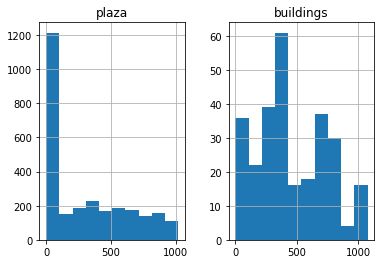

In [231]:
df.hist()

In [232]:
pd.options.display.float_format = '{:,.1f}'.format
df.describe()

,plaza,buildings
count,"2,723.0",279.0
mean,297.0,450.6
std,322.5,282.1
min,0.0,0.0
25%,0.0,274.8
50%,198.8,369.7
75%,567.9,700.2
max,"1,021.2","1,076.1"


In [233]:
import json 
b = b_results[0] 
legend_par = json.loads(b['@legend_par'])
legend_par

{'are_colors_default': None,
 'base_plane': None,
 'colors': ['0,0,0', '91,49,112', '191,47,100', '225,226,99', '248,251,224'],
 'continuous_legend': False,
 'decimal_coun': False,
 'font': None,
 'include_larger_smaller': 1,
 'max': 1100.0,
 'min': 0.0,
 'segment_count': 12,
 'segment_height': None,
 'text_height': None,
 'title': 'kWh/m2',
 'vertical': True}

In [209]:
# print(custom_colors)


# print(custom_colors_remap)

In [1]:
import os
os.environ["GSHEET_ID"] = "17oH61DLGHjllLqrNOX2Tx8oc69qyYCEHrlkMvnDL1Tg"

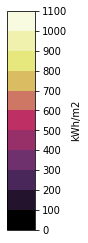

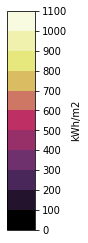

In [234]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# color bar from matplotlib 
def colorBar(legend_par):
    # remap rgb from 0 - 255 to  0 - 1
    def remap_rgb(col):
        def remap(num):
            return np.interp(num, [0, 255], [0, 1]).round(4)

        cols = [remap(col) for col in col.split(',')]

        return tuple(cols)

    # remap colors
    colors_remap = [remap_rgb(col) for col in legend_par['colors']]

    # parse data from legend_par
    low = float(legend_par['min'])
    high = float(legend_par['max'])
    num_div = int(legend_par['segment_count'])
    include_larger_smaller = 'neither' if legend_par['include_larger_smaller'] else 'both'
    vertical = 'vertical' if legend_par['vertical'] else 'horizontal'
    title = legend_par['title']

    # create bounds
    bounds = np.linspace(low, high, num_div)

    # adjust plot size if vertical
    figsize = (0.5, 8) if vertical else (8, 1)

    # create figure
    fig, ax = plt.subplots(figsize=figsize)  # figsize=(6, 1)
    fig.subplots_adjust(bottom=0.5)

    # cmap = mpl.cm.viridis # matplotlib colors
    # cmap = (mpl.colors.ListedColormap(['royalblue', 'cyan', 'yellow', 'orange'])
    #         .with_extremes(over='red', under='blue')) # extra colors for the extremes

    # create color map from rgb list
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "lb_colors", colors_remap)

    legend_par['continuous_legend'] = False
    # change normalization in 'continuous_legend'
    if legend_par['continuous_legend']:
        norm = mpl.colors.Normalize(vmin=low, vmax=high)
    else:
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=include_larger_smaller) # 'max' 'min' 'both' 'neither'

    # plot colorbar with matplotlib
    fig.colorbar(mpl.cm.ScalarMappable(
        norm=norm,
        cmap=cmap),
        cax=ax,
        orientation=vertical,
        ticks=bounds,
        label=title, 
        ) # additional arguments aspect, 
    
    # plt.savefig('color_bar.png', bbox_inches='tight')
    return fig


color_bar = colorBar(legend_par)
color_bar


In [ ]:


# get the specified commit data
commit = client.commit.get(STREAM_ID, COMMIT_ID)

# create an authenticated server transport from the client and receive the commit obj
transport = ServerTransport(STREAM_ID, client)
res = operations.receive(commit.referencedObject, transport)

# get the list of levels from the received object
# levels = res["data"]

base = res["@data"][0][0][0][0][0]
base

df_values = base["@DF_values"]

df = pd.DataFrame(df_values, columns=['df_values'])

print(df.head())

In [ ]:
# initialise and authenticate your client
stream_id = "62e5ff6a2b"
account = get_default_account()
client = SpeckleClient(host=account.serverInfo.url)
client.authenticate(token=account.token)
transport = ServerTransport(client=client, stream_id=stream_id)

# get the `globals` branch
branch = client.branch.get(stream_id, "globals")

# get the latest commit
latest_commit = branch.commits.items[0]

# receive the globals object
globs = operations.receive(latest_commit.referencedObject, transport)